Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Integrity checks passed: 
  model=baseline_lstm.keras 
  X_test_scaled=(502, 40, 7), y_test=(502,) 
  lookback=40, n_features=7

===== Running Robustness for ±1% =====
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/metrics/rq5_feature_robustness_overall_sign_1pct.csv
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/metrics/rq5_feature_robustness_by_regime_sign_1pct.csv
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_top_features_abs_dy_1pct.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_top_features_flip_rate_1pct.png


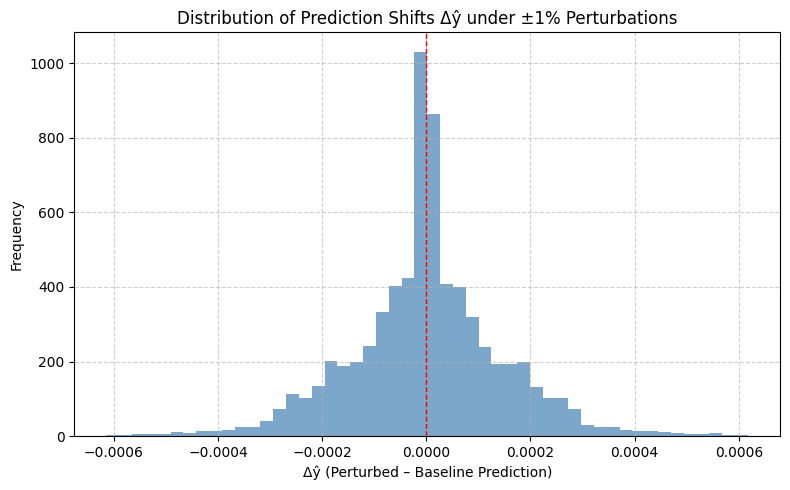

 Δŷ histogram saved to: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_dy_histogram_1pct.png

===== Running Robustness for ±3% =====
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/metrics/rq5_feature_robustness_overall_sign_3pct.csv
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/metrics/rq5_feature_robustness_by_regime_sign_3pct.csv
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_top_features_abs_dy_3pct.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_top_features_flip_rate_3pct.png


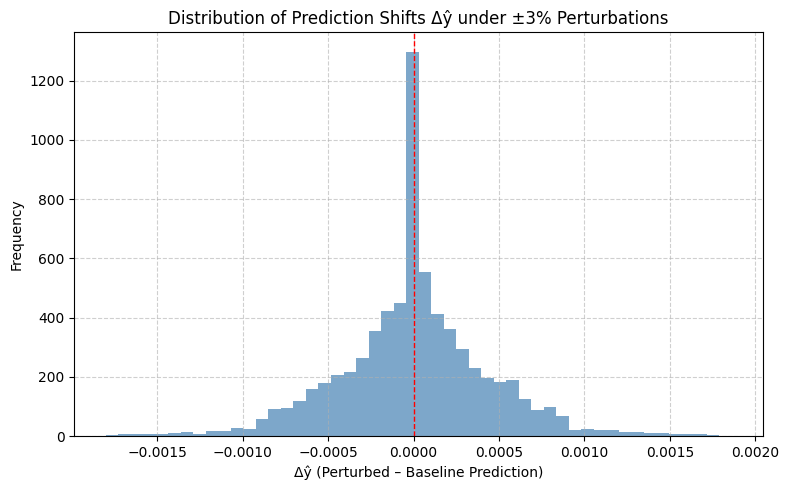

 Δŷ histogram saved to: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_dy_histogram_3pct.png

===== Running Robustness for ±5% =====
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/metrics/rq5_feature_robustness_overall_sign_5pct.csv
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/metrics/rq5_feature_robustness_by_regime_sign_5pct.csv
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_top_features_abs_dy_5pct.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_top_features_flip_rate_5pct.png


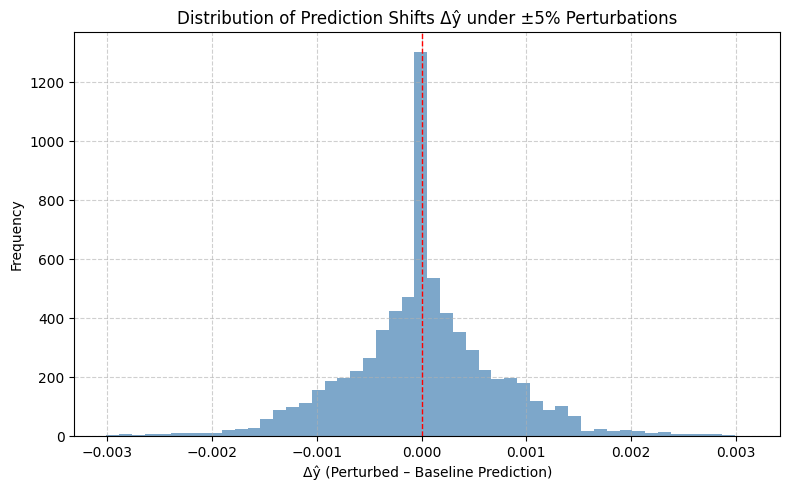

 Δŷ histogram saved to: /content/drive/MyDrive/nvda_rnn_forecasting/results/figures/rq5_dy_histogram_5pct.png


In [ ]:
# ============================================
# RQ5 — Input Robustness (Multi-perturbation: ±1%, ±3%, ±5%)
# ============================================


import os, json, numpy as np, pandas as pd

project_path = os.getenv('PROJECT_PATH', '.')
ART = os.path.join(project_path, "artifacts")
RESULTS_MET = os.path.join(project_path, "results", "metrics")
RESULTS_FIG = os.path.join(project_path, "results", "figures")
RESULTS_ATTR = os.path.join(project_path, "results", "attributions")
os.makedirs(RESULTS_MET, exist_ok=True)
os.makedirs(RESULTS_FIG, exist_ok=True)
os.makedirs(RESULTS_ATTR, exist_ok=True)

# Helper for saving figures
def savefig(path, fig=None, dpi=300):
    import matplotlib.pyplot as plt
    (fig or plt.gcf()).savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved:", path)

# ---- Imports & Integrity checks ----
import hashlib, joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def _sha256(p):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(524288), b""): h.update(chunk)
    return h.hexdigest()

# Load manifests/meta
assert os.path.isdir(ART), f"Artifacts folder missing: {ART}"
manifest = json.load(open(os.path.join(ART, "manifest.json")))
meta     = json.load(open(os.path.join(ART, "meta.json")))
feat_names = meta["features"]
lookback   = int(meta["lookback"])
n_feats    = len(feat_names)

# Model: single checkpoint everywhere
model_path = os.path.join(ART, "baseline_lstm.keras")
assert os.path.exists(model_path), "baseline_lstm.keras not found"
assert _sha256(model_path) == manifest["files"]["baseline_model"]["sha256"], "Model hash mismatch — wrong checkpoint?"
model = load_model(model_path)

# Arrays
X_test_scaled = np.load(os.path.join(ART, "X_test_scaled.npy")).astype(np.float32)
y_test        = np.load(os.path.join(ART, "y_test.npy"))
assert X_test_scaled.shape[1] == lookback,  "Look-back mismatch"
assert X_test_scaled.shape[2] == n_feats,   "Feature-count mismatch"
assert len(y_test) == X_test_scaled.shape[0], "y_test length != X_test rows"

# Scalers
feat_scaler = joblib.load(os.path.join(ART, "feature_scaler_standard.pkl"))
tgt_scaler  = joblib.load(os.path.join(ART, "target_scaler_standard.pkl"))
if hasattr(feat_scaler, "n_features_in_"):
    assert feat_scaler.n_features_in_ == n_feats, "Scaler.n_features_in_ != feature count"

print("Integrity checks passed:",
      f"\n  model={os.path.basename(model_path)}",
      f"\n  X_test_scaled={X_test_scaled.shape}, y_test={y_test.shape}",
      f"\n  lookback={lookback}, n_features={n_feats}")

# Recreate unscaled test sequences & baseline predictions
N, T, F = X_test_scaled.shape
flat = X_test_scaled.reshape(-1, F)
X_test_unscaled = feat_scaler.inverse_transform(flat).reshape(N, T, F).astype(np.float32)

# Baseline predictions (on scaled test)
y_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()
y_pred = tgt_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = y_test.copy()

pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).to_csv(
    os.path.join(RESULTS_MET, "rq5_test_predictions.csv"), index=False
)

base_regime = (y_pred > 0).astype(int)  # 1=bull, 0=bear

#Helper functions
def _seq_scale_with_existing_scaler(X_seq_unscaled, scaler):
    n, t, f = X_seq_unscaled.shape
    flat = X_seq_unscaled.reshape(-1, f)
    flat_scaled = scaler.transform(flat)
    return flat_scaled.reshape(n, t, f).astype(np.float32)

def _predict_from_unscaled(model, X_seq_unscaled, feat_scaler, tgt_scaler):
    X_scaled = _seq_scale_with_existing_scaler(X_seq_unscaled, feat_scaler)
    y_s = model.predict(X_scaled, verbose=0).flatten()
    return tgt_scaler.inverse_transform(y_s.reshape(-1, 1)).flatten()

def _predict_from_scaled(model, X_scaled, tgt_scaler):
    y_s = model.predict(X_scaled, verbose=0).flatten()
    return tgt_scaler.inverse_transform(y_s.reshape(-1,1)).flatten()

def _rescale_with_scaler(X_unscaled, scaler):
    n, t, f = X_unscaled.shape
    flat = X_unscaled.reshape(-1, f)
    flat_sc = scaler.transform(flat)
    return flat_sc.reshape(n, t, f).astype(np.float32)

from sklearn.metrics import mean_squared_error, mean_absolute_error

def _reg_metrics(y_true, yhat):
    mse  = mean_squared_error(y_true, yhat)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, yhat)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

def _pct_change(new, base): return 100.0 * (new - base) / (base + 1e-12)

#  Multi-Epsilon Loop
EPSILONS = [0.01, 0.03, 0.05]
for eps in EPSILONS:
    tag = f"{int(eps*100)}pct"
    print(f"\n===== Running Robustness for ±{int(eps*100)}% =====")
    rows = []
    rows_regime = []

    for j, fname in enumerate(feat_names):
        # ±eps multiplicative shock applied to ALL timesteps of feature j
        Xp = X_test_unscaled.copy()
        Xm = X_test_unscaled.copy()
        Xp[..., j] *= (1.0 + eps)
        Xm[..., j] *= (1.0 - eps)

        # Predict perturbed returns
        y_pred_p = _predict_from_unscaled(model, Xp, feat_scaler, tgt_scaler)
        y_pred_m = _predict_from_unscaled(model, Xm, feat_scaler, tgt_scaler)

        # Regime from predicted sign
        reg_p = (y_pred_p > 0).astype(int)
        reg_m = (y_pred_m > 0).astype(int)

        # Δŷ
        dyp = y_pred_p - y_pred
        dym = y_pred_m - y_pred

        # Flip-rates vs baseline regime
        flips_plus  = (reg_p != base_regime).mean()
        flips_minus = (reg_m != base_regime).mean()

        # Elasticity using last-step feature value
        last_feat_vals = X_test_unscaled[:, -1, j]
        denom = eps * (last_feat_vals + 1e-12)
        elast_p = dyp / (denom + 1e-12)
        elast_m = dym / (denom + 1e-12)

        rows.append({
            "feature": fname,
            "mean_dy_plus": float(np.mean(dyp)),
            "mean_abs_dy_plus": float(np.mean(np.abs(dyp))),
            "mean_dy_minus": float(np.mean(dym)),
            "mean_abs_dy_minus": float(np.mean(np.abs(dym))),
            "mean_elasticity_plus": float(np.mean(elast_p)),
            "mean_elasticity_minus": float(np.mean(elast_m)),
            "symmetry_score": float(
                1.0 - (np.mean(np.abs(dyp + dym)) /
                    (np.mean(np.abs(dyp)) + np.mean(np.abs(dym)) + 1e-12))
            ),
            "flip_rate_sign_plus": float(flips_plus),
            "flip_rate_sign_minus": float(flips_minus),
        })

        # Regime-conditional summaries (group by BASELINE predicted regime)
        for lbl, name in [(0, "Bear"), (1, "Bull")]:
            idx = np.where(base_regime == lbl)[0]
            if idx.size == 0:
                continue
            rows_regime.append({
                "feature": fname,
                "regime": name,
                "n_samples": int(idx.size),
                "mean_abs_dy_plus": float(np.mean(np.abs(dyp[idx]))),
                "mean_abs_dy_minus": float(np.mean(np.abs(dym[idx]))),
                "flip_rate_sign_plus": float((reg_p[idx] != base_regime[idx]).mean()),
                "flip_rate_sign_minus": float((reg_m[idx] != base_regime[idx]).mean()),
                "mean_elast_plus": float(np.mean(elast_p[idx])),
                "mean_elast_minus": float(np.mean(elast_m[idx])),
            })

    robust_df = pd.DataFrame(rows).sort_values("mean_abs_dy_plus", ascending=False).reset_index(drop=True)
    robust_regime_df = pd.DataFrame(rows_regime)

    # Robustness Index relative to baseline variability
    pred_scale = np.std(y_pred) + 1e-12
    robust_df["RI_plus"]  = 1.0 - (robust_df["mean_abs_dy_plus"]  / pred_scale)
    robust_df["RI_minus"] = 1.0 - (robust_df["mean_abs_dy_minus"] / pred_scale)
    robust_df["RI_mean"]  = robust_df[["RI_plus", "RI_minus"]].mean(axis=1)

    # Save tables
    p_overall = os.path.join(RESULTS_MET, f"rq5_feature_robustness_overall_sign_{tag}.csv")
    p_regime  = os.path.join(RESULTS_MET, f"rq5_feature_robustness_by_regime_sign_{tag}.csv")
    robust_df.to_csv(p_overall, index=False)
    robust_regime_df.to_csv(p_regime, index=False)
    print("Saved:", p_overall)
    print("Saved:", p_regime)

    # Plots: |Δŷ| and flip-rates (top-k)
    topk = min(10, n_feats)
    # Plot for mean absolute Δŷ
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    bars = robust_df.head(topk).plot(
        x="feature",
        y=["mean_abs_dy_plus", "mean_abs_dy_minus"],
        kind="bar",
        rot=45,
        title=f"Top Features by |Δŷ| (±{int(eps*100)}% perturbation)",
        ax=ax1
    )
    # Add data labels
    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if not np.isnan(height):
                bars.annotate(f'{height:.2e}',  # Scientific notation for small values
                              xy=(bar.get_x() + bar.get_width() / 2, height),
                              xytext=(0, 3),  # Offset text above the bar
                              textcoords="offset points",
                              ha='center', va='bottom', fontsize=8, rotation=90)
    plt.tight_layout()
    savefig(os.path.join(RESULTS_FIG, f"rq5_top_features_abs_dy_{tag}.png"))
    plt.close()

    # Plot for regime flip rates
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    bars = robust_df.head(topk).plot(
        x="feature",
        y=["flip_rate_sign_plus", "flip_rate_sign_minus"],
        kind="bar",
        rot=45,
        title=f"Top Features by Regime Flip Rate (±{int(eps*100)}%)",
        ax=ax2
    )
    # Add data labels
    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if not np.isnan(height):
                bars.annotate(f'{height:.3f}',
                              xy=(bar.get_x() + bar.get_width() / 2, height),
                              xytext=(0, 3),
                              textcoords="offset points",
                              ha='center', va='bottom', fontsize=8, rotation=90)
    plt.tight_layout()
    savefig(os.path.join(RESULTS_FIG, f"rq5_top_features_flip_rate_{tag}.png"))
    plt.close()


    # ---- Histogram of Δŷ across all perturbations ----
    all_dy = []
    for j, fname in enumerate(feat_names):
        Xp = X_test_unscaled.copy()
        Xm = X_test_unscaled.copy()
        Xp[..., j] *= (1.0 + eps)
        Xm[..., j] *= (1.0 - eps)

        y_pred_p = _predict_from_unscaled(model, Xp, feat_scaler, tgt_scaler)
        y_pred_m = _predict_from_unscaled(model, Xm, feat_scaler, tgt_scaler)

        dyp = y_pred_p - y_pred
        dym = y_pred_m - y_pred

        all_dy.extend(dyp.tolist())
        all_dy.extend(dym.tolist())

    all_dy = np.array(all_dy)
    plt.figure(figsize=(8,5))
    plt.hist(all_dy, bins=50, color="steelblue", alpha=0.7)
    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.title(f"Distribution of Prediction Shifts Δŷ under ±{int(eps*100)}% Perturbations")
    plt.xlabel("Δŷ (Perturbed – Baseline Prediction)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    hist_path = os.path.join(RESULTS_FIG, f"rq5_dy_histogram_{tag}.png")
    plt.savefig(hist_path, dpi=300)
    plt.close()
    print(f" Δŷ histogram saved to: {hist_path}")




In [ ]:
# ---- Export whole-set ±eps arrays for SHAP (RQ3b) ----
Xp_all_plus_unscaled  = X_test_unscaled * (1.0 + eps)
Xp_all_minus_unscaled = X_test_unscaled * (1.0 - eps)
Xp_all_plus_scaled  = _rescale_with_scaler(Xp_all_plus_unscaled,  feat_scaler)
Xp_all_minus_scaled = _rescale_with_scaler(Xp_all_minus_unscaled, feat_scaler)

np.save(os.path.join(ART, f"Xp_all_plus_scaled_{tag}.npy"),  Xp_all_plus_scaled)
np.save(os.path.join(ART, f"Xp_all_minus_scaled_{tag}.npy"), Xp_all_minus_scaled)
print(" Exported for RQ3b:",
        os.path.join(ART, f"Xp_all_plus_scaled_{tag}.npy"),
        os.path.join(ART, f"Xp_all_minus_scaled_{tag}.npy"))



 Exported for RQ3b: /content/drive/MyDrive/nvda_rnn_forecasting/artifacts/Xp_all_plus_scaled_5pct.npy /content/drive/MyDrive/nvda_rnn_forecasting/artifacts/Xp_all_minus_scaled_5pct.npy


In [ ]:
    # ---- Tiny summary for the report ----
summary = robust_df[[
        "feature","mean_abs_dy_plus","mean_abs_dy_minus",
        "flip_rate_sign_plus","flip_rate_sign_minus","RI_mean","symmetry_score"
    ]].copy()
summary.to_csv(os.path.join(RESULTS_MET, f"rq5_summary_table_{tag}.csv"), index=False)
print(f"Saved summary: rq5_summary_table_{tag}.csv")

    # === Whole-set ±eps shocks: metrics & flip rates (for Table 4.5 / Table 4.6) ===
Xp_all_plus_scaled  = np.load(os.path.join(ART, f"Xp_all_plus_scaled_{tag}.npy"))
Xp_all_minus_scaled = np.load(os.path.join(ART, f"Xp_all_minus_scaled_{tag}.npy"))

y_pred_all_plus  = _predict_from_scaled(model, Xp_all_plus_scaled,  tgt_scaler)
y_pred_all_minus = _predict_from_scaled(model, Xp_all_minus_scaled, tgt_scaler)

m_baseline = _reg_metrics(y_true, y_pred)
m_plus     = _reg_metrics(y_true, y_pred_all_plus)
m_minus    = _reg_metrics(y_true, y_pred_all_minus)

metrics_summary = {
        "baseline": m_baseline,
        f"+{tag}_all": {k: float(v) for k,v in m_plus.items()},
        f"-{tag}_all": {k: float(v) for k,v in m_minus.items()},
        "pct_change_vs_baseline": {
            "MSE":  _pct_change(m_plus["MSE"],  m_baseline["MSE"]),
            "RMSE": _pct_change(m_plus["RMSE"], m_baseline["RMSE"]),
            "MAE":  _pct_change(m_plus["MAE"],  m_baseline["MAE"]),
        }
    }

with open(os.path.join(RESULTS_MET, f"rq5_metrics_baseline_vs_perturbed_{tag}.json"), "w") as f:
        json.dump(metrics_summary, f, indent=2)

    # Regime flips under whole-set shocks (relative to baseline predicted regime)
reg_base  = (y_pred > 0).astype(int)
reg_plus  = (y_pred_all_plus > 0).astype(int)
reg_minus = (y_pred_all_minus > 0).astype(int)

flip_summary = pd.DataFrame({
        "scenario": [f"+{int(eps*100)}% all features", f"-{int(eps*100)}% all features"],
        "flip_rate_vs_baseline": [
            float((reg_plus  != reg_base).mean()),
            float((reg_minus != reg_base).mean())
        ]
    })
flip_summary.to_csv(os.path.join(RESULTS_MET, f"rq5_label_flip_summary_{tag}.csv"), index=False)
print(metrics_summary)
print(flip_summary.to_string(index=False))

print("\n==== DONE! All robustness experiments for 1%, 3%, 5% completed ====")

Saved summary: rq5_summary_table_5pct.csv
{'baseline': {'MSE': 0.007298523673637933, 'RMSE': 0.08543139746977065, 'MAE': 0.06772366056852433}, '+5pct_all': {'MSE': 0.007273024459447409, 'RMSE': 0.08528202893603909, 'MAE': 0.06762132985050344}, '-5pct_all': {'MSE': 0.00732823107356179, 'RMSE': 0.08560508789529854, 'MAE': 0.06785740985692608}, 'pct_change_vs_baseline': {'MSE': -0.34937496029686854, 'RMSE': -0.17484032586808684, 'MAE': -0.1511003941020567}}
        scenario  flip_rate_vs_baseline
+5% all features               0.011952
-5% all features               0.007968

==== DONE! All robustness experiments for 1%, 3%, 5% completed ====
